# RQ4: To what extent can Machine Learning/NLP models identify the sensemaking aspect of feedback?

## Part 1: Machine Learning Models with TF-IDF Feature Extraction

This is the first part of research question 4 where we will be classifying sensemaking in the feedback data with the TF-IDF feature extraction technique and four classification models:
- Logistic Regression
- Support Vector Machine
- Random Forest
- XGBoost Classifier

### 1. Importing the Libraries and the Data

We need to import the below libraries first to produce the desired outcome:

In [1]:
# Importing the required libraries
import pandas as pd
import re
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Furthermore, after importing the libraries, we can use the `Pandas` library to load the cleaned feedback csv file into a dataframe.

In [152]:
# Importing the feedback data with Pandas
data = pd.read_csv('./LabelledFeedback/stage2.csv')

# Isolating the useful columns
data = data[['SentenceScoreRem', 'Rubric']]

# Checking the imported data
data.head()

,SentenceScoreRem,Rubric
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1
2,The team submitted the workbook 23 days after ...,Sensemaking 2
3,Risk assessment and report needs work as discu...,Sensemaking 1
4,"""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1


### 2. Preprocessing the Text

As is visible in the above output, there is a lot dirty text in the feedback data such as punctuations and stop words. Using the text in its raw form may not give us the desired results on the classification model. Therefore, we need to preprocess the data before attempting to extract the features.

We can use the `NLTK` library to clean the feedback text by tokenizing it and removing the stop words. For deeper context, stop words represent the text that acts more like connectors and it may not provide much context about the data.

In [153]:
# Defining a function to clean the feedback text
def clean_text(text):

    # Changing the case of the characters in the text
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

    # Tokenizing the text
    tokens = nltk.word_tokenize(text)

    # Downloading the stopwords from the NLTK corpus
    stopwords = nltk.corpus.stopwords.words('english')

    # Remvoing the stopwords from the set of tokens
    filtered_tokens = [token for token in tokens if token not in stopwords]

    # Joining the tokens
    clean_text = ' '.join(filtered_tokens)

    # Returning the cleaned text
    return clean_text

# Applying the preprocessing function to the data
data['cleaned_text'] = data['SentenceScoreRem'].apply(clean_text)

In [154]:
# Checking the cleaned data
data

,SentenceScoreRem,Rubric,cleaned_text
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,yuejing depth analysis required see link key c...
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,team requested workbook better original mark
2,The team submitted the workbook 23 days after ...,Sensemaking 2,team submitted workbook days submission date kv
3,Risk assessment and report needs work as discu...,Sensemaking 1,risk assessment report needs work discussed tu...
4,"""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1,good effort please refer detailed feedback fil...
...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,q need use english communicate partiularly par...
5755,"In part (b), which was more complicated than i...",Sensemaking 1,part b complicated needed explain rate change ...
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,q english exposition required
5757,You made two errors: finding the determinant i...,Sensemaking 1,made two errors finding determinant part b fin...


To answer the first part of this research question, we are going to train three types models. They differ based on the target variable. Since we are trying to predict the sensemaking aspect, we need to understand whether it can be predicted at different granularities. Those granularities are:

- Sensemaking vs. The Rest
- Sensemaking 1 vs. Sensemaking 2
- Sensemaking & Future Impact vs. The Rest

### 3. Training the Models - Sensemaking vs. The Rest

#### 3.1 Creating the Target Variable

The first step is to define a function that will create the target variable for this model type. We will create a binary target variable called `Sensemaking` whose value is 1 if the sensemaking component is present in the text and 0 if the sensemaking component is not present in that text.

In [155]:
# Defining a function to check for the sensemaking component in the text
def sensemaking(rub):

    # If condition to check if there is any sensemaking rubric in the Rubric column
    if 'Sensemaking' in rub:

        return 1

    else:

        return 0

# Applying the sensemaking function to the data
data['Sensemaking'] = data['Rubric'].apply(lambda x : sensemaking(x))

In [156]:
# Checking the new target variable column
data[['cleaned_text', 'Rubric', 'Sensemaking']]

,cleaned_text,Rubric,Sensemaking
0,yuejing depth analysis required see link key c...,Sensemaking 1&Impact 1,1
1,team requested workbook better original mark,Impact 1,0
2,team submitted workbook days submission date kv,Sensemaking 2,1
3,risk assessment report needs work discussed tu...,Sensemaking 1,1
4,good effort please refer detailed feedback fil...,Agency 2&Agency 1,0
...,...,...,...
5754,q need use english communicate partiularly par...,Impact 1,0
5755,part b complicated needed explain rate change ...,Sensemaking 1,1
5756,q english exposition required,Impact 2,0
5757,made two errors finding determinant part b fin...,Sensemaking 1,1


#### 3.2 Creating the Train/Test Split and Extracting the Features

We now have our cleaned text and the target variable. We need to split the data into the training data and test data. The training data will be used to train the model and the testing data will be used to validate the model. We can use the `train_test_split` function from the `sklearn` library to split the data. 80% of the data will be used to train the model and 20% of the data will be used to validate the model.

In [157]:
# Defining the features
features = data['cleaned_text']

# Defining the target variable
target = data['Sensemaking']

# Spliting the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [158]:
# Viewing information about the train and test datasets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4607,)
Number transactions y_train dataset:  (4607,)
Number transactions X_test dataset:  (1152,)
Number transactions y_test dataset:  (1152,)


An important step to be taken in the model building process of a classification model is to ensure that the target variable is balanced. If one class is more prevalent than the other, it is given more importance by the model and this will degrade the model performance.

First, let us check the value counts of each class in the target variable.

In [159]:
# Checking if the training data is balanced
print(y_train.value_counts())

Sensemaking
1    2581
0    2026
Name: count, dtype: int64


We can see that the counts for both classes are almost the same. It is important to note that class balancing techniques help to balance the data but there is also a chance of overfitting when the difference in the value counts is not significant. Therefore, we do not need to balance the data in this case.

In the next step, we will perform the final operation on the data before training the model. The feature extraction method to be used here is TF-IDF.TF-IDF creates a specific representation of numbers for the text that holds some meaning. We can use the `TF-IDF` function in the `sklearn` library to do this. We will transform the train and test data.

In [160]:
# Extracting the features with TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### 3.3 Training the Data

With our text fully vectorised, we are ready to run our models. We can use the `sklearn` library to train and fit the logistic regression, SVM and random forest models and the `xgboost` library to fit the xgboost model to the data.

In [161]:
# Fitting the Logistic Regression model to the data
# Contributed by: Ahmad Aldino (ahmad.aldino@monash.edu)
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_pred)
print(classification_report(y_test, lr_pred))

# Fitting the Support Vector Machine model to the data
svm_model = SVC(probability=True)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
print(classification_report(y_test, svm_pred))

# Fitting the Random Forest model to the data
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_pred)
print(classification_report(y_test, rf_pred))

# # Fitting the XGBoost model to the data
xgb_model = XGBClassifier().fit(X_train_tfidf, y_train)
xgb_pred = xgb_model.predict(X_test_tfidf)
xgb_acc = accuracy_score(xgb_pred, y_test)
print(classification_report(y_test, xgb_pred))

# Printing the accuracies for the 4 models
print("Logistic Regression Accuracy:", lr_acc)
print("Support Vector Machine Accuracy:", svm_acc)
print("Random Forest Accuracy:", rf_acc)
print('XGBoost Accuracy:', xgb_acc)

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       500
           1       0.84      0.91      0.87       652

    accuracy                           0.85      1152
   macro avg       0.85      0.84      0.84      1152
weighted avg       0.85      0.85      0.85      1152

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       500
           1       0.85      0.93      0.89       652

    accuracy                           0.87      1152
   macro avg       0.87      0.86      0.86      1152
weighted avg       0.87      0.87      0.86      1152

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       500
           1       0.84      0.92      0.88       652

    accuracy                           0.86      1152
   macro avg       0.86      0.85      0.85      1152
weighted avg       0.86      0.86      0.86      1152

              preci

We have the  below metrics for each model as given in the above output:

- Accuracy
- Precision
- Recall
- F1 Score

Now, we will plot the ROC (Receiver Operating Characteristic) Curve for each of the models to get a visual representation of the model performance.

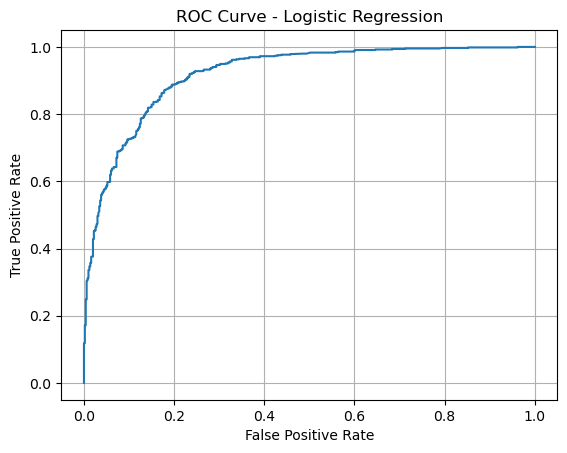

In [162]:
# Computing the metrics to plot the curve for logistic regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log = lr_model.predict_proba(X_test_tfidf)[::,1]
fpr_log_case1, tpr_log_case1, _ = roc_curve(y_test,  y_pred_proba_log)

# Generating the ROC curve for the logistic regression model
plt.plot(fpr_log_case1,tpr_log_case1)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

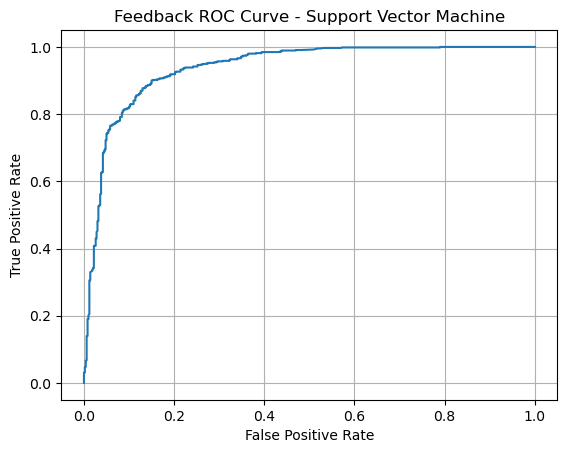

In [163]:
# Computing the metrics to plot the curve for Support Vector Machine
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[::,1]
fpr_svm_case1, tpr_svm_case1, _ = roc_curve(y_test,  y_pred_proba_svm)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_case1,tpr_svm_case1)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

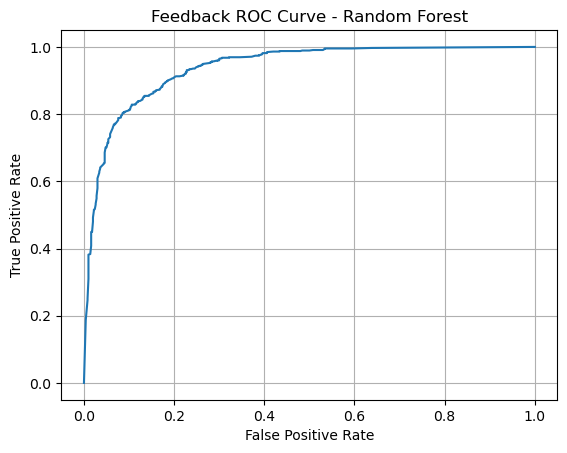

In [164]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[::,1]
fpr_rf_case1, tpr_rf_case1, _ = roc_curve(y_test,  y_pred_proba_rf)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_case1,tpr_rf_case1)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

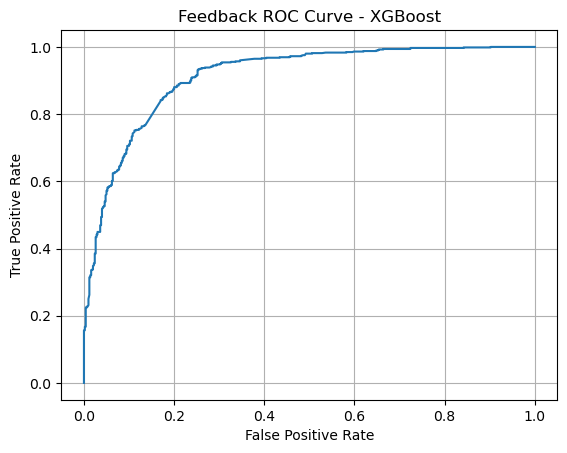

In [165]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[::,1]
fpr_xgb_case1, tpr_xgb_case1, _ = roc_curve(y_test,  y_pred_proba_xgb)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_case1,tpr_xgb_case1)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

We can also add the ROC curves in the same plot for better visuals

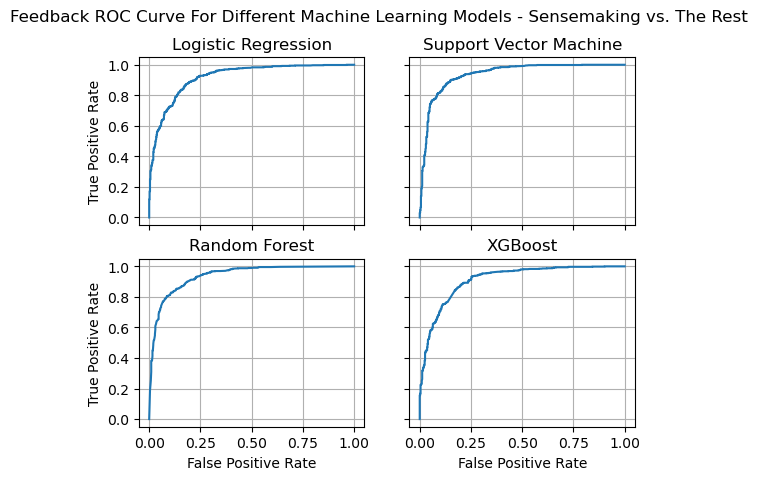

In [166]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Assigning the subplot title
fig.suptitle('Feedback ROC Curve For Different Machine Learning Models - Sensemaking vs. The Rest')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case1,tpr_log_case1)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case1,tpr_svm_case1)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_case1,tpr_rf_case1)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_case1,tpr_xgb_case1)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the plot
plt.show()

### 4. Training the Models - Sensemaking 1 vs. Sensemaking 2

In the second run of classification models, we want to check whether they can identify the sensemaking rubrics in the text.

#### 4.1. Filtering the Data and Creating the Target Variable

The first step we will take here is to isolate the data which contains any sensemaking rubrics. We can create a new dataframe for this section.

In [167]:
# Filtering the data by the rubric column
df_sensemaking = data[data["Rubric"].str.contains("Sensemaking")]

In [168]:
# Checking the filtered rubrics
print(df_sensemaking['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Sensemaking 1' 'Sensemaking 2&Impact 2'
 'Sensemaking 1&Sensemaking 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 2&Sensemaking 1&Impact 1' 'Sensemaking 1&Impact 1&Agency 2']


We can see that there are lots of rubric combinations that have the sensemaking 1 and 2 rubrics in them. Since we are trying to develop a model that can identify either of these two rubrics, we need the text to have only one of them. We need to discard them from the data for the purposes of this research question.

In [169]:
# Filtering the data by the sensemaking rubrics.
df_sensemaking = df_sensemaking[~df_sensemaking['Rubric'].str.contains('Sensemaking 2&Sensemaking 1')]
df_sensemaking = df_sensemaking[~df_sensemaking['Rubric'].str.contains('Sensemaking 1&Sensemaking 2')]

In [170]:
# Checking the filtered data
print(df_sensemaking['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Impact 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 1&Impact 1&Agency 2']


In [171]:
# Taking the necessary columns
df_sensemaking = df_sensemaking[['Rubric', 'cleaned_text']]

In this section, we will define a new function to create a new target variable that assigns 1 if the text contains the sensemaking 1 rubric and 0 otherwise.

In [172]:
# Defining a function to create the target variable
def sensemaking2(rub):

    # If condition to check if the sensemaking 1 rubric is in the Rubric column
    if 'Sensemaking 1' in rub:

        return 1

    else:

        return 0

# Applying the function to the data
df_sensemaking['Sensemaking_Rubric'] = df_sensemaking['Rubric'].apply(lambda x : sensemaking2(x))

In [173]:
# Checking the target variable
df_sensemaking

,Rubric,cleaned_text,Sensemaking_Rubric
0,Sensemaking 1&Impact 1,yuejing depth analysis required see link key c...,1
2,Sensemaking 2,team submitted workbook days submission date kv,0
3,Sensemaking 1,risk assessment report needs work discussed tu...,1
6,Sensemaking 1,lacked depth detail,1
7,Sensemaking 2,failed cite use prescribed texts answers simpl...,0
...,...,...,...
5751,Sensemaking 1,q f x g x incorrect shown found stationary poi...,1
5753,Sensemaking 1&Impact 1,part c actually still part b part c required c...,1
5755,Sensemaking 1,part b complicated needed explain rate change ...,1
5757,Sensemaking 1,made two errors finding determinant part b fin...,1


#### 4.2 Splitting the Data

With the new target variable created successfully, let us split the data into training and testing and check the distribution of the target variable. We will use the same 80-20 ratio to split the data

In [174]:
# Defining the features
features = df_sensemaking['cleaned_text']

# Defining the target variable
target = df_sensemaking['Sensemaking_Rubric']

# Splitting the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [175]:
# Viewing information about the train and test data sets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2525,)
Number transactions y_train dataset:  (2525,)
Number transactions X_test dataset:  (632,)
Number transactions y_test dataset:  (632,)


#### 4.3 Extracting the Features and Handling Class Imbalance

Now, we will check whether the training data is balanced or not.

In [176]:
# Checking the value counts of the target variable
print(y_train.value_counts())

Sensemaking_Rubric
1    2183
0     342
Name: count, dtype: int64


Unlike the first case, we can see that there is a significant class imbalance in the data. We need to balance the data by using a method called SMOTE. But first, to use this balancing technique, we need to vectorize the data.

In [177]:
# Applying the TF-IDF vectorization to the data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

We can use `SMOTE`, which stands for Synthetic Minority Over-sampling to handle the class imbalance. It is available for use in the `imblearn` library in Python. `SMOTE` is a method that generates synthetic samples to replace the missing samples of the minority class. The advantage of using `SMOTE` over other oversampling methods is that the samples it creates are not exact duplicates but computed with the help of a KNN technique. Therefore, the possibility of overfitting is reduced to a great extent. 

In [178]:
# Reference: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Importing SMOTE from the imblearn library
from imblearn.over_sampling import SMOTE

# Importing the Counter function from collections
from collections import Counter

# Defining the SMOTE function
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

# Checking the before and after state of the class balancing operation
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({1: 2183, 0: 342})
Resample dataset shape Counter({1: 2183, 0: 2183})


We can see that SMOTE has successfully managed to balance the distribution of the target variable in the data.

#### 4.4 Training the Models

We can run our 4 models in the same manner as the first case of this notebook.

In [179]:
# Fitting the Logistic Regression model to the data
# Contributed by: Ahmad Aldino (ahmad.aldino@monash.edu)
lr_model = LogisticRegression()
lr_model.fit(x_smote, y_smote)
lr_pred = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_pred)
print(classification_report(y_test, lr_pred))

# Fitting the Support Vector Machine model to the data
svm_model = SVC(probability=True)
svm_model.fit(x_smote, y_smote)
svm_pred = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
print(classification_report(y_test, svm_pred))

# Fitting the Random Forest model to the data
rf_model = RandomForestClassifier()
rf_model.fit(x_smote, y_smote)
rf_pred = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_pred)
print(classification_report(y_test, rf_pred))

# Fitting the XGBoost model to the data
xgb_model = XGBClassifier().fit(x_smote, y_smote)
xgb_pred = xgb_model.predict(X_test_tfidf)
xgb_acc = accuracy_score(xgb_pred, y_test)
print(classification_report(y_test, xgb_pred))

# Printing the accuracy for each model
print("Logistic Regression Accuracy:", lr_acc)
print("Support Vector Machine Accuracy:", svm_acc)
print("Random Forest Accuracy:", rf_acc)
print('XGBoost Accuracy:', xgb_acc)

              precision    recall  f1-score   support

           0       0.72      0.73      0.73        82
           1       0.96      0.96      0.96       550

    accuracy                           0.93       632
   macro avg       0.84      0.84      0.84       632
weighted avg       0.93      0.93      0.93       632

              precision    recall  f1-score   support

           0       0.82      0.65      0.72        82
           1       0.95      0.98      0.96       550

    accuracy                           0.94       632
   macro avg       0.88      0.81      0.84       632
weighted avg       0.93      0.94      0.93       632

              precision    recall  f1-score   support

           0       0.81      0.66      0.72        82
           1       0.95      0.98      0.96       550

    accuracy                           0.94       632
   macro avg       0.88      0.82      0.84       632
weighted avg       0.93      0.94      0.93       632

              preci

Let us generate the ROC curves for these models

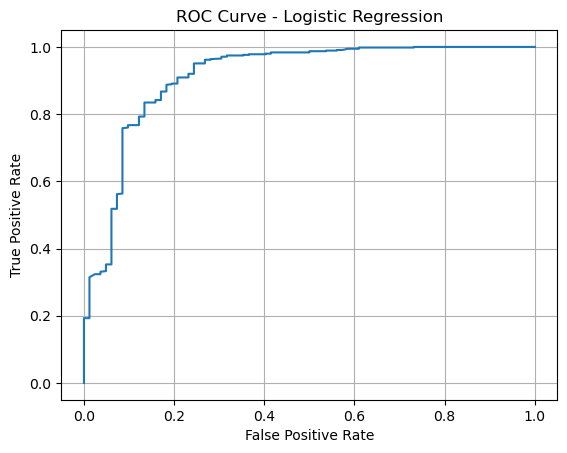

In [180]:
# Computing the metrics to plot the curve for Logistic Regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log = lr_model.predict_proba(X_test_tfidf)[::,1]
fpr_log_case2, tpr_log_case2, _ = roc_curve(y_test,  y_pred_proba_log)

# Generating the ROC curve for the Logistic Regression model
plt.plot(fpr_log_case2,tpr_log_case2)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

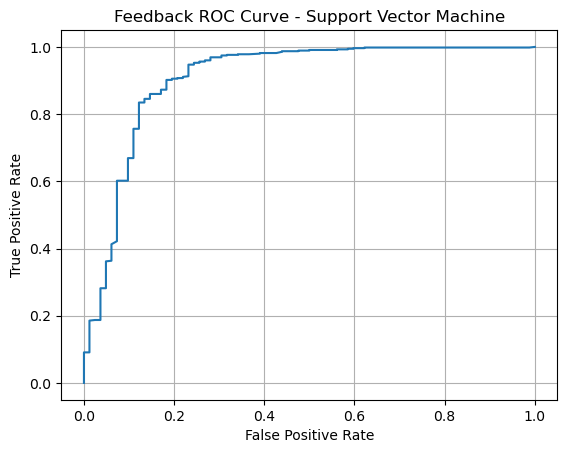

In [181]:
# Computing the metrics to plot the curve for SVM
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[::,1]
fpr_svm_case2, tpr_svm_case2, _ = roc_curve(y_test,  y_pred_proba_svm)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_case2,tpr_svm_case2)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

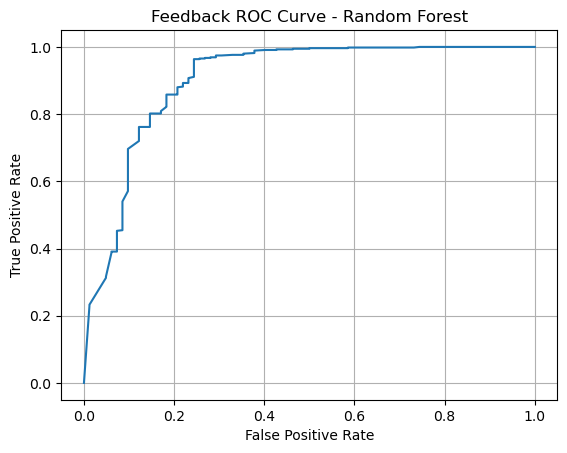

In [182]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[::,1]
fpr_rf_case2, tpr_rf_case2, _ = roc_curve(y_test,  y_pred_proba_rf)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_case2,tpr_rf_case2)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

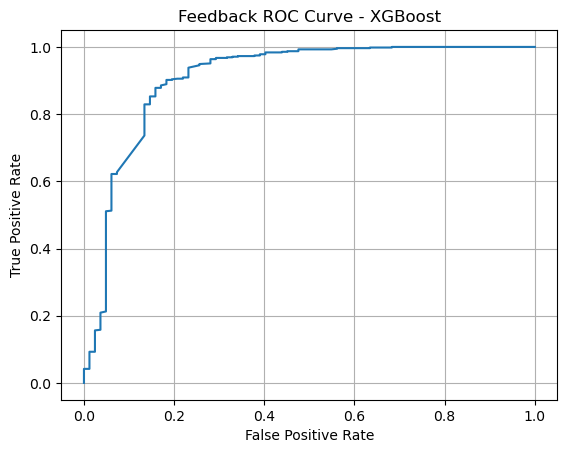

In [183]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[::,1]
fpr_xgb_case2, tpr_xgb_case2, _ = roc_curve(y_test,  y_pred_proba_xgb)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_case2,tpr_xgb_case2)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

Let us combine these ROC plots as follows:

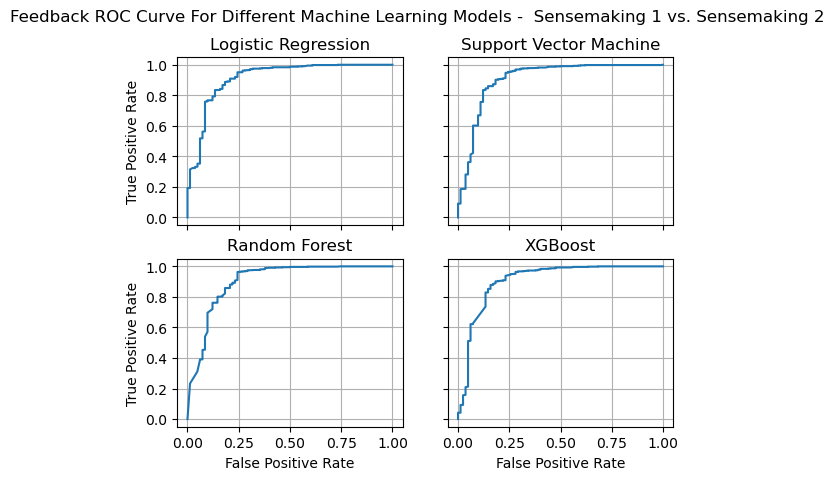

In [184]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

fig.suptitle('Feedback ROC Curve For Different Machine Learning Models -  Sensemaking 1 vs. Sensemaking 2')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case2,tpr_log_case2)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case2,tpr_svm_case2)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_case2,tpr_rf_case2)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_case2,tpr_xgb_case2)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the plot
plt.show()

### 5. Training the Models - Sensemaking & Future Impact  vs. The Rest

#### 5.1 Creating the target variable and Splitting the Data

In this third set of models, we will define a function to create a new target variable that is assigned 1 if the text contains a sensemaking and future impact rubric simultaneously and 0 otherwise.

In [185]:
# Defining a function to detect the sensemaking and future impact rubrics
def sensemaking_impact(rub):

    # If condition to check for both sensemaking and future impact
    if 'Sensemaking' in rub and 'Impact' in rub:

        return 1

    else:

        return 0

# Applying the function to the data
data['Sensemaking_Impact'] = data['Rubric'].apply(lambda x : sensemaking_impact(x))

As was the case earlier, let us check the value counts of the target variable for this data.

In [186]:
print(data['Sensemaking_Impact'].value_counts())

Sensemaking_Impact
0    5255
1     504
Name: count, dtype: int64


We can see a clear imbalance in the data. Once we split this data into training and testing, we will have to use SMOTE to balance it. Let us split the data in the next step.

In [187]:
# Defining the features
features = data['cleaned_text']

# Defining the target variable
target = data['Sensemaking_Impact']

# Splitting the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [188]:
# Viewing information about the train and test data sets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4607,)
Number transactions y_train dataset:  (4607,)
Number transactions X_test dataset:  (1152,)
Number transactions y_test dataset:  (1152,)


#### 5.2 Vectorizing the Training Data and Handling the Class Imbalance

Now that we have split the data, we can perform the TF-IDF feature extraction process to vectorise it.

In [189]:
# Performing the TF-IDF feature extraction and applying it to the data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Next, we will apply the balancing method `SMOTE` to the training data.

In [190]:
# Reference: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Importing SMOTE from the imblearn library
from imblearn.over_sampling import SMOTE
from collections import Counter

# Defining the SMOTE function
smote = SMOTE()

# Fitting the smote function to the predictor and target variable of the training data
x_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)

# Checking the before and after state of the balancing operation on the data
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 4194, 1: 413})
Resample dataset shape Counter({0: 4194, 1: 4194})


#### 5.3 Training the Classification Models

With our data ready for training, we can train the models as follows:

In [191]:
# Fitting the Logistic Regression model to the data
# Contributed by: Ahmad Aldino (ahmad.aldino@monash.edu)
lr_model = LogisticRegression()
lr_model.fit(x_smote, y_smote)
lr_pred = lr_model.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_pred)
print(classification_report(y_test, lr_pred))

# Fitting the SVM model to the data
svm_model = SVC(probability=True)
svm_model.fit(x_smote, y_smote)
svm_pred = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
print(classification_report(y_test, svm_pred))

# Fitting the Random Forest model to the data
rf_model = RandomForestClassifier()
rf_model.fit(x_smote, y_smote)
rf_pred = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_pred)
print(classification_report(y_test, rf_pred))

# Fitting the XGBoost model to the data
xgb_model = XGBClassifier().fit(x_smote, y_smote)
xgb_pred = xgb_model.predict(X_test_tfidf)
xgb_acc = accuracy_score(xgb_pred, y_test)
print(classification_report(y_test, xgb_pred))

# Printing the accuracy for each of the models
print("Logistic Regression Accuracy:", lr_acc)
print("Support Vector Machine Accuracy:", svm_acc)
print("Random Forest Accuracy:", rf_acc)
print('XGBoost Accuracy:', xgb_acc)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1061
           1       0.40      0.65      0.50        91

    accuracy                           0.90      1152
   macro avg       0.68      0.78      0.72      1152
weighted avg       0.92      0.90      0.91      1152

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1061
           1       0.72      0.45      0.55        91

    accuracy                           0.94      1152
   macro avg       0.84      0.72      0.76      1152
weighted avg       0.94      0.94      0.94      1152

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1061
           1       0.82      0.51      0.63        91

    accuracy                           0.95      1152
   macro avg       0.89      0.75      0.80      1152
weighted avg       0.95      0.95      0.95      1152

              preci

Let us produce the ROC curves for these new set of models

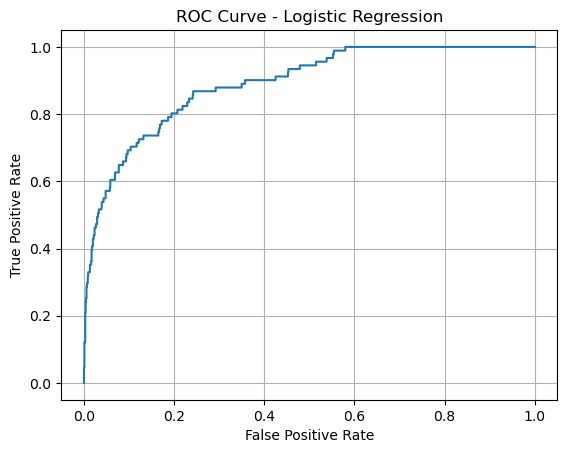

In [192]:
# Computing the metrics to plot the curve for Logistic Regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log = lr_model.predict_proba(X_test_tfidf)[::,1]
fpr_log_case3, tpr_log_case3, _ = roc_curve(y_test,  y_pred_proba_log)

# Generating the ROC curve for the Logistic Regression model
plt.plot(fpr_log_case3,tpr_log_case3)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

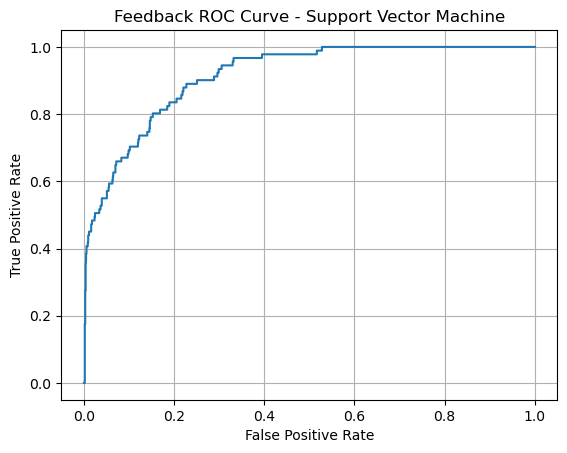

In [193]:
# Computing the metrics to plot the curve for Support Vector Machine
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm = svm_model.predict_proba(X_test_tfidf)[::,1]
fpr_svm_case3, tpr_svm_case3, _ = roc_curve(y_test,  y_pred_proba_svm)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_case3,tpr_svm_case3)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

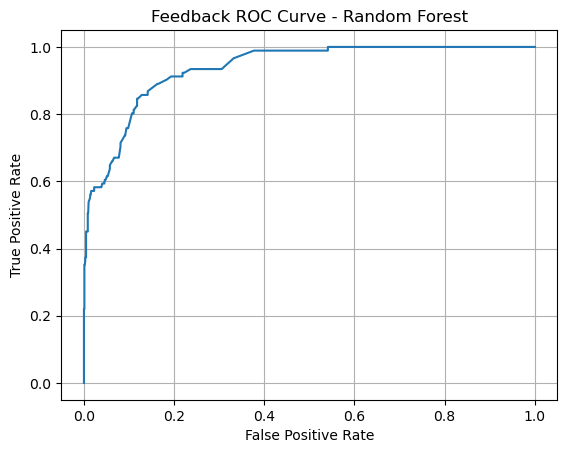

In [194]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[::,1]
fpr_rf_case3, tpr_rf_case3, _ = roc_curve(y_test,  y_pred_proba_rf)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_case3,tpr_rf_case3)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

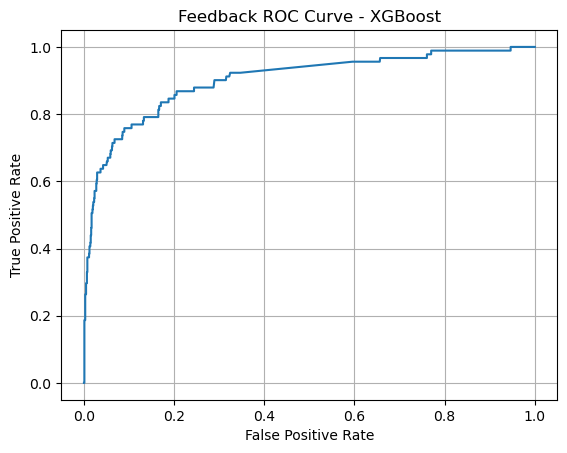

In [195]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[::,1]
fpr_xgb_case3, tpr_xgb_case3, _ = roc_curve(y_test,  y_pred_proba_xgb)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_case3,tpr_xgb_case3)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

Now, let us combine the ROC plots.

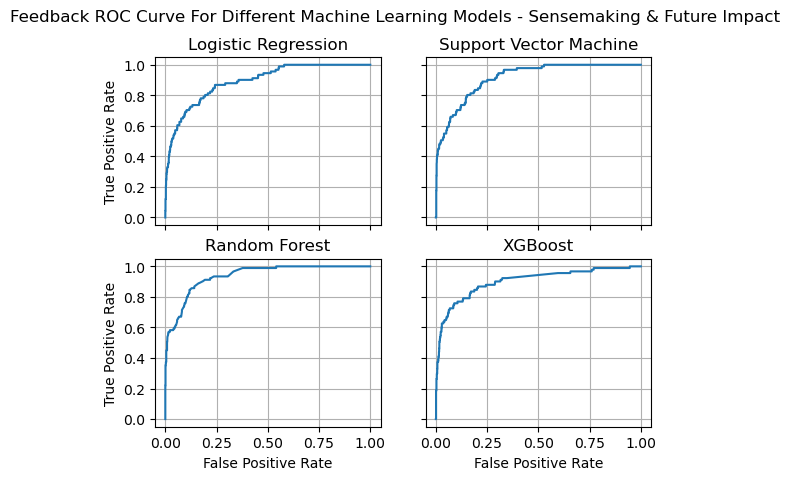

In [196]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Different Machine Learning Models - Sensemaking & Future Impact')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case3,tpr_log_case3)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case3,tpr_svm_case3)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_case3,tpr_rf_case3)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_case3,tpr_xgb_case3)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

## Part 2: Machine Learning Models with LIWC (Linguistic Inquiry Word Count) Feature Extraction

In this section, we will train 4 models (Logistic Regression, Support Vector Machine, Random Forest, XGBoost) for the three scenarios(Sensemaking vs. The Rest; Sensemaking 1 vs. Sensemaking 2; Sensemaking & Impact vs. The Rest). We will follow the same set of steps that were followed for Part 1 with one difference. 

In part 2, we will extract the features with LIWC instead of TF-IDF. The goal is to compare both methods and choose the most optimum feature extraction - model method. Let us start this section by loading the necessary libraries.

### 1. Importing the Libraries and the Data

In [3]:
# Installing the xgboost library
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 845.9 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [52]:
# Importing the necessary libraries.
import pandas as pd
import re
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will be loading a slightly different version of the feedback data in part 2. This data has been passed through the LIWC application interface. This application accepts a dataset and upon selecting the text column, it generates the appropriate linguistic features for the data. For more details about these categories, please see this document: [LIWC](https://www.liwc.app/static/documents/LIWC-22%20Manual%20-%20Development%20and%20Psychometrics.pdf)


These linguistic variables are created in the form of a regular `csv` file that can be loaded into a Pandas dataframe.

In [197]:
# Loading the LIWC csv data into a Pandas dataframe
data_LIWC = pd.read_csv('./LabelledFeedback/LIWC-22 Results - stage2 - LIWC Analysis.csv')

In [198]:
# Checking the data
data_LIWC.head()

,Unnamed: 0,SentenceLabelRem,SentenceScoreRem,Rubric,Score,FeedbackCode,Segment,WC,Analytic,Clout,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,0,Yuejing more in depth analysis is required and...,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,58.33,1,1,15,22.17,96.04,...,0.0,0.0,6.67,6.67,0.00,0.0,0.0,0.0,0.00,0
1,1,Team 1 requested to re-do their workbook 3 to ...,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,1,15,96.08,99.00,...,0.0,0.0,13.33,6.67,0.00,0.0,0.0,0.0,6.67,0
2,2,The team submitted the workbook 23 days after ...,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,1,12,99.00,84.23,...,0.0,0.0,8.33,8.33,0.00,0.0,0.0,0.0,0.00,0
3,3,Risk assessment and report needs work as discu...,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,1,10,89.52,40.06,...,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0
4,4,"""Good effort, Please refer to detailed feedbac...","""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1,60.60,4,1,9,98.16,40.06,...,0.0,0.0,33.33,11.11,11.11,0.0,0.0,0.0,11.11,0


As shown in the above view of the data, we can see several columns that contain numerical data. Each of these columns represent a linguistic feature and the numeric values represent the occurence of that feature in the given feedback text. Please refer to the link provided at the top of this notebook to understand more about the linguistic categories these features belong to.

### 2. Training the Models - Sensemaking vs. The Rest

As executed for part 1, we will prepare the data for the three model scenarios starting with Sensemaking vs. the rest. Let us go ahead and write a function that will create the target variable for the first scenario.

In [199]:
# Defining a function to detect the sensemaking element in the data
def sensemaking(rub):

    if 'Sensemaking' in rub:

        return 1

    else:

        return 0

# Applying the function to the LIWC-extracted data    
data_LIWC['Sensemaking'] = data_LIWC['Rubric'].apply(lambda x : sensemaking(x))

In [200]:
# Dropping the unncessary columns
dataNew_LIWC = data_LIWC.drop(['Unnamed: 0', 'SentenceLabelRem', 'SentenceScoreRem'], axis = 1)

Now that we have our target variable, let us go about defining the features and the label columns. For the features, we are going to select all those LIWC extracted features. Furthermore, we can use the `train_test_split` module from the `sklearn` library to split the data.

In [201]:
# Split the preprocessed data into features and target variable
features_LIWC = dataNew_LIWC.drop(['FeedbackCode', 'Rubric', 'Score', 'Sensemaking'], axis = 1)
target_LIWC = dataNew_LIWC['Sensemaking']

In [202]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_LIWC, target_LIWC, test_size=0.2, random_state=42)

We split the data 80-20 with 80% of the data training the model and the remaining 20% validating it. We can execute the four models now, using the training and testing data sets.

In [203]:
# Logistic Regression
lr_model_LIWC = LogisticRegression()
lr_model_LIWC.fit(X_train, y_train)
lr_pred_LIWC = lr_model_LIWC.predict(X_test)
lr_acc_LIWC = accuracy_score(y_test, lr_pred_LIWC)
print(classification_report(y_test, lr_pred_LIWC))

# Support Vector Machine
svm_model_LIWC = SVC(probability = True)
svm_model_LIWC.fit(X_train, y_train)
svm_pred_LIWC = svm_model_LIWC.predict(X_test)
svm_acc_LIWC = accuracy_score(y_test, svm_pred_LIWC)
print(classification_report(y_test, svm_pred_LIWC))

# Random Forest
rf_model_LIWC = RandomForestClassifier()
rf_model_LIWC.fit(X_train, y_train)
rf_pred_LIWC = rf_model_LIWC.predict(X_test)
rf_acc_LIWC = accuracy_score(y_test, rf_pred_LIWC)
print(classification_report(y_test, rf_pred_LIWC))

# XGBoost
xgb_model_LIWC = XGBClassifier().fit(X_train, y_train)
xgb_pred_LIWC = xgb_model_LIWC.predict(X_test)
xgb_acc_LIWC = accuracy_score(xgb_pred_LIWC, y_test)
print(classification_report(y_test, xgb_pred_LIWC))


print("Logistic Regression Accuracy:", lr_acc_LIWC)
print("Support Vector Machine Accuracy:", svm_acc_LIWC)
print("Random Forest Accuracy:", rf_acc_LIWC)
print('XGBoost Accuracy:', xgb_acc_LIWC)

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       500
           1       0.73      0.76      0.75       652

    accuracy                           0.71      1152
   macro avg       0.70      0.70      0.70      1152
weighted avg       0.71      0.71      0.71      1152

              precision    recall  f1-score   support

           0       0.81      0.66      0.73       500
           1       0.77      0.88      0.82       652

    accuracy                           0.79      1152
   macro avg       0.79      0.77      0.78      1152
weighted avg       0.79      0.79      0.78      1152

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       500
           1       0.83      0.93      0.88       652

    accuracy                           0.85      1152
   macro avg       0.86      0.84      0.85      1152
weighted avg       0.86      0.85      0.85      1152

              preci

We have the four metrics for each of the models including Accuracy, Precision, Recall and F1-score. To get a visual representation of the performance of the model, we can construct the ROC plot for each of these models.

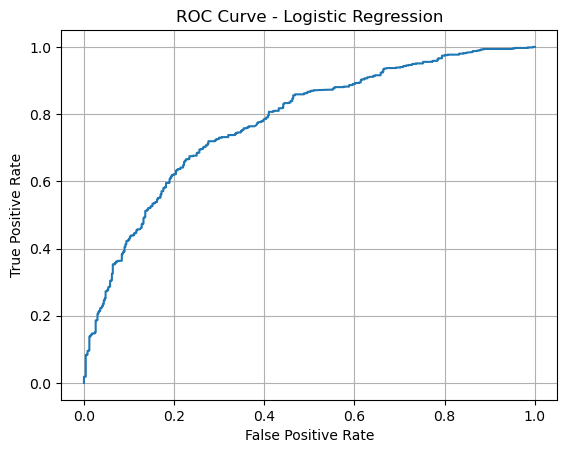

In [204]:
# Computing the metrics to plot the curve for Logistic Regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log_LIWC = lr_model_LIWC.predict_proba(X_test)[::,1]
fpr_log_LIWC_case1, tpr_log_LIWC_case1, _ = roc_curve(y_test,  y_pred_proba_log_LIWC)

# Generating the ROC curve for the Logistic Regression model
plt.plot(fpr_log_LIWC_case1,tpr_log_LIWC_case1)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

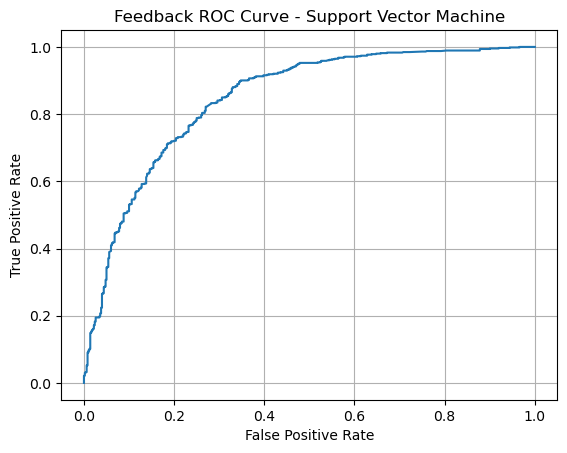

In [205]:
# Computing the metrics to plot the curve for Support Vector Machine
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm_LIWC = svm_model_LIWC.predict_proba(X_test)[::,1]
fpr_svm_LIWC_case1, tpr_svm_LIWC_case1, _ = roc_curve(y_test,  y_pred_proba_svm_LIWC)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_LIWC_case1,tpr_svm_LIWC_case1)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

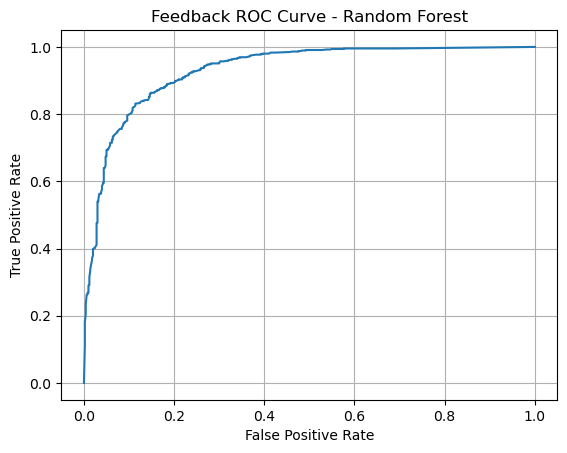

In [206]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf_LIWC = rf_model_LIWC.predict_proba(X_test)[::,1]
fpr_rf_LIWC_case1, tpr_rf_LIWC_case1, _ = roc_curve(y_test,  y_pred_proba_rf_LIWC)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_LIWC_case1, tpr_rf_LIWC_case1)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

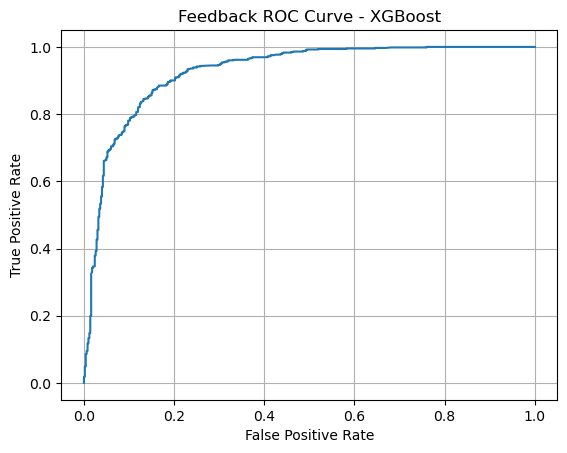

In [207]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb_LIWC = xgb_model_LIWC.predict_proba(X_test)[::,1]
fpr_xgb_LIWC_case1, tpr_xgb_LIWC_case1, _ = roc_curve(y_test,  y_pred_proba_xgb_LIWC)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_LIWC_case1, tpr_xgb_LIWC_case1)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

Now, let us combine the ROC plots for the 4 LIWC engineered models.

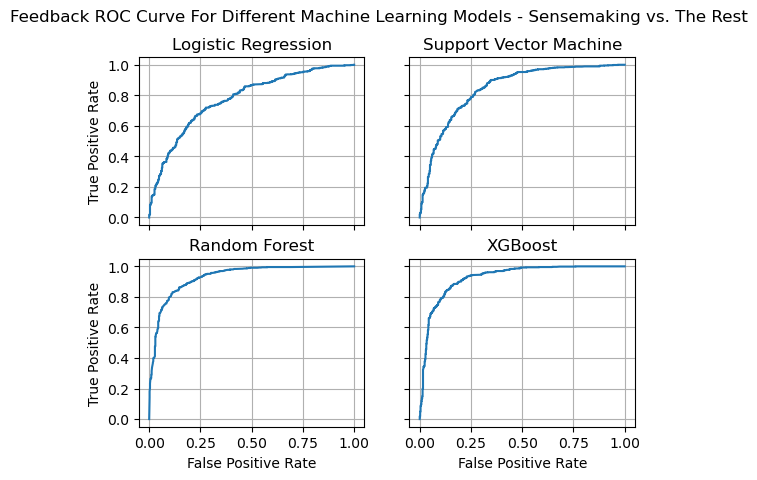

In [208]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Different Machine Learning Models - Sensemaking vs. The Rest')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_LIWC_case1,tpr_log_LIWC_case1)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_LIWC_case1,tpr_svm_LIWC_case1)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_LIWC_case1,tpr_rf_LIWC_case1)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_LIWC_case1,tpr_xgb_LIWC_case1)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

Unliked the TF-IDF extracted features, the LIWC features represent a linguistic category that is present in the text. Therefore, it is quite useful to rank these features and see which features are the most important. As shown in the above outputs, the LIWC-XGBoost model had the best performance. Therefore, we can use the `XGBoost` Feature importance  to rank the features. 

In [209]:
# Importing the xgboost library
import xgboost as xgb

# Separating the features (X) and the target variable (y)
X = features_LIWC
y = target_LIWC

# Converting the data into DMatrix format for XGBoost
dmatrix = xgb.DMatrix(X, label=y)

# Setting the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Training the XGBoost model
model = xgb.train(params, dmatrix)

# Computing the feature importance
feature_importance = model.get_score(importance_type='weight')

# Creating a dataframe to display the feature importance
importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()),
                              'Importance': list(feature_importance.values())})

# Sorting the features in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Isolating the top 10 most important features
top_10_features = importance_df.head(10)

# Printing the top ten features
print(top_10_features)

         Feature  Importance
25          verb        20.0
21       auxverb        15.0
69  focuspresent        15.0
7            Dic        13.0
36       discrep        13.0
62        allure        12.0
47        Social        12.0
68     focuspast        11.0
20          prep        11.0
6       BigWords        10.0


### 3. Training the Models - Sensemaking 1 vs. Sensemaking 2

In this section, we are going to train models for the second case similar to part 1 but this time with the LIWC extracted features. The set of steps to be followed as the same for the most part. However, like case 2 of part 1, we will filter the data to only include those rows where the text has at least one and at most one sensemaking rubric.

In [210]:
# Filtering the data by the rubric column
df_sensemaking_LIWC = data_LIWC[data_LIWC["Rubric"].str.contains("Sensemaking")]

In [211]:
# Checking the filtered rubrics
print(df_sensemaking_LIWC['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Sensemaking 1' 'Sensemaking 2&Impact 2'
 'Sensemaking 1&Sensemaking 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 2&Sensemaking 1&Impact 1' 'Sensemaking 1&Impact 1&Agency 2']


In [212]:
# Filtering the data by the sensemaking rubrics.
df_sensemaking_LIWC = df_sensemaking_LIWC[~df_sensemaking_LIWC['Rubric'].str.contains('Sensemaking 2&Sensemaking 1')]
df_sensemaking_LIWC = df_sensemaking_LIWC[~df_sensemaking_LIWC['Rubric'].str.contains('Sensemaking 1&Sensemaking 2')]

In [213]:
# Checking the filtered data
print(df_sensemaking_LIWC['Rubric'].unique())

['Sensemaking 1&Impact 1' 'Sensemaking 2' 'Sensemaking 1'
 'Sensemaking 1&Impact 2' 'Agency 2&Sensemaking 1'
 'Sensemaking 2&Impact 2' 'Sensemaking 1&Impact 3'
 'Sensemaking 2&Impact 1' 'Impact 1&Sensemaking 1'
 'Sensemaking 1&Agency 1' 'Agency 2&Sensemaking 2'
 'Sensemaking 1&Agency 2' 'Impact 2&Sensemaking 1'
 'Sensemaking 2&Agency 2' 'Agency 1&Sensemaking 1'
 'Impact 3&Sensemaking 1' 'Agency 3&Sensemaking 1'
 'Sensemaking 2&Agency 3' 'Agency 2&Sensemaking 1&Impact 1'
 'Sensemaking 2&Agency 1' 'Agency 2&Sensemaking 1&Agency 1'
 'Sensemaking 1&Impact 1&Agency 2']


The function to be defined for case 2 checks the data for the presence of the Sensemaking 1 rubric and assigns a value of 1 for those rows and 0 otherwise.

In [214]:
# Defining a function to create the target variable
def sensemaking2(rub):

    # If condition to check if the sensemaking 1 rubric is in the Rubric column
    if 'Sensemaking 1' in rub:

        return 1

    else:

        return 0

# Applying the function to the data
df_sensemaking_LIWC['Sensemaking_Rubric'] = df_sensemaking_LIWC['Rubric'].apply(lambda x : sensemaking2(x))

Next, we can drop the unncecessary columns and split the data into training and testing data sets.

In [215]:
# Storing the features separately
features_LIWC = df_sensemaking_LIWC.drop(['Unnamed: 0', 'SentenceLabelRem', 'SentenceScoreRem', 'FeedbackCode', 'Rubric', 'Score', 'Sensemaking', 'Sensemaking_Rubric'], axis = 1)

# Storing the target variable or label separately
target_LIWC = df_sensemaking_LIWC['Sensemaking_Rubric']

In [216]:
# Splitting the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(features_LIWC, target_LIWC, test_size=0.2, random_state=42)

In [217]:
# Viewing information about the train and test data sets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2525, 119)
Number transactions y_train dataset:  (2525,)
Number transactions X_test dataset:  (632, 119)
Number transactions y_test dataset:  (632,)


In [218]:
# Checking the value counts of the target variable
print(y_train.value_counts())

Sensemaking_Rubric
1    2183
0     342
Name: count, dtype: int64


The value counts of the target variable for this case show the imbalance as this is the same subset we encountered in case 2 of Part 1. Therefore, we will be using the oversampling method `SMOTE` to handle the imbalance in the data set. Since the LIWC generated features also contain numerical values, we can use this method here. 

We will load the `SMOTE` oversampler from the `imblearn` library.

In [219]:
# Reference: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Importing SMOTE from the imblearn library
from imblearn.over_sampling import SMOTE

# Importing the Counter function from collections
from collections import Counter

# Defining the SMOTE function
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

# Checking the before and after state of the class balancing operation
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({1: 2183, 0: 342})
Resample dataset shape Counter({1: 2183, 0: 2183})


As shown in the before and after image of the data in the above output, we have managed to balance the data. We can train the 4 models with this smote-balanced data.

In [220]:
# Fitting the Logistic Regression model to the data
# Contributed by: Ahmad Aldino (ahmad.aldino@monash.edu)
lr_model_LIWC = LogisticRegression()
lr_model_LIWC.fit(x_smote, y_smote)
lr_pred_LIWC = lr_model_LIWC.predict(X_test)
lr_acc_LIWC = accuracy_score(y_test, lr_pred_LIWC)
print(classification_report(y_test, lr_pred_LIWC))

# Fitting the Support Vector Machine model to the data
svm_model_LIWC = SVC(probability=True)
svm_model_LIWC.fit(x_smote, y_smote)
svm_pred_LIWC = svm_model_LIWC.predict(X_test)
svm_acc_LIWC = accuracy_score(y_test, svm_pred_LIWC)
print(classification_report(y_test, svm_pred_LIWC))

# Fitting the Random Forest model to the data
rf_model_LIWC = RandomForestClassifier()
rf_model_LIWC.fit(x_smote, y_smote)
rf_pred_LIWC = rf_model_LIWC.predict(X_test)
rf_acc_LIWC = accuracy_score(y_test, rf_pred_LIWC)
print(classification_report(y_test, rf_pred_LIWC))

# Fitting the XGBoost model to the data
xgb_model_LIWC = XGBClassifier().fit(x_smote, y_smote)
xgb_pred_LIWC = xgb_model_LIWC.predict(X_test)
xgb_acc_LIWC = accuracy_score(xgb_pred_LIWC, y_test)
print(classification_report(y_test, xgb_pred_LIWC))

# Printing the accuracy for each model
print("Logistic Regression Accuracy:", lr_acc_LIWC)
print("Support Vector Machine Accuracy:", svm_acc_LIWC)
print("Random Forest Accuracy:", rf_acc_LIWC)
print('XGBoost Accuracy:', xgb_acc_LIWC)

              precision    recall  f1-score   support

           0       0.35      0.63      0.45        82
           1       0.94      0.82      0.88       550

    accuracy                           0.80       632
   macro avg       0.64      0.73      0.66       632
weighted avg       0.86      0.80      0.82       632

              precision    recall  f1-score   support

           0       0.41      0.66      0.51        82
           1       0.94      0.86      0.90       550

    accuracy                           0.83       632
   macro avg       0.68      0.76      0.70       632
weighted avg       0.88      0.83      0.85       632

              precision    recall  f1-score   support

           0       0.79      0.55      0.65        82
           1       0.94      0.98      0.96       550

    accuracy                           0.92       632
   macro avg       0.86      0.76      0.80       632
weighted avg       0.92      0.92      0.92       632

              preci

To visually represent the metrics of a classification model, an ROC curve is most suited. Therefore, let us construct ROC curves for each of the models.

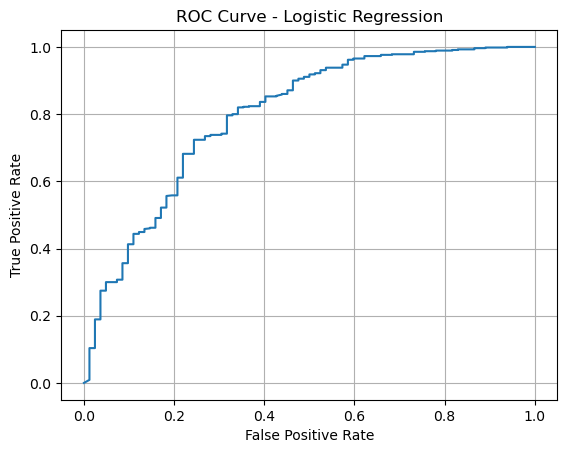

In [221]:
# Computing the metrics to plot the curve for Logistic Regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log_LIWC = lr_model_LIWC.predict_proba(X_test)[::,1]
fpr_log_LIWC_case2, tpr_log_LIWC_case2, _ = roc_curve(y_test,  y_pred_proba_log_LIWC)

# Generating the ROC curve for the Logistic Regression model
plt.plot(fpr_log_LIWC_case2,tpr_log_LIWC_case2)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

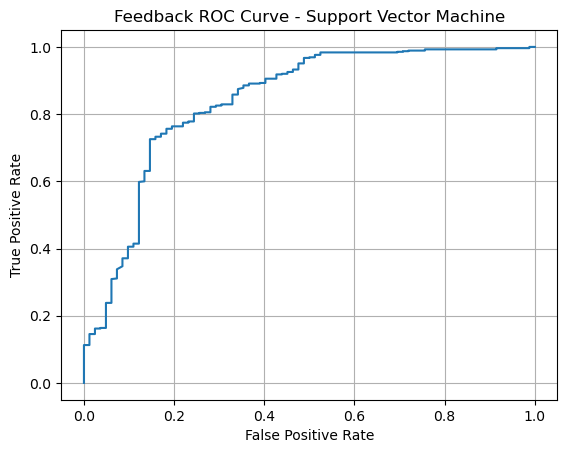

In [222]:
# Computing the metrics to plot the curve for Support Vector Machine
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm_LIWC = svm_model_LIWC.predict_proba(X_test)[::,1]
fpr_svm_LIWC_case2, tpr_svm_LIWC_case2, _ = roc_curve(y_test,  y_pred_proba_svm_LIWC)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_LIWC_case2,tpr_svm_LIWC_case2)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

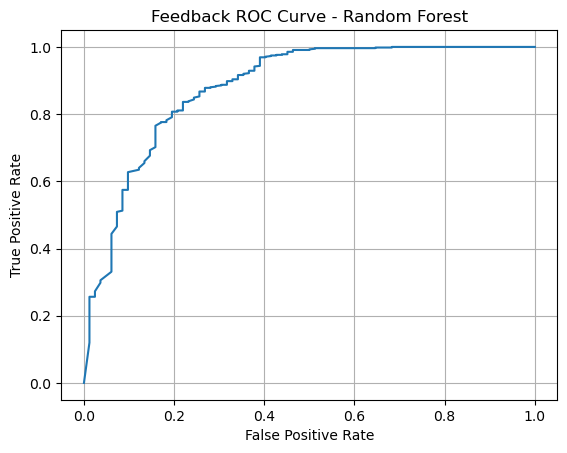

In [223]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf_LIWC = rf_model_LIWC.predict_proba(X_test)[::,1]
fpr_rf_LIWC_case2, tpr_rf_LIWC_case2, _ = roc_curve(y_test,  y_pred_proba_rf_LIWC)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_LIWC_case2,tpr_rf_LIWC_case2)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

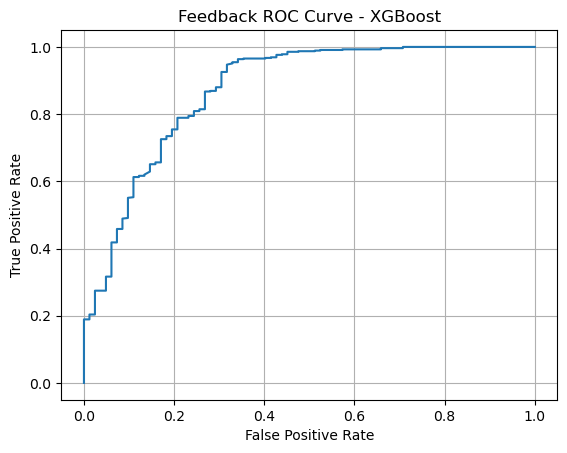

In [224]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb_LIWC = xgb_model_LIWC.predict_proba(X_test)[::,1]
fpr_xgb_LIWC_case2, tpr_xgb_LIWC_case2, _ = roc_curve(y_test,  y_pred_proba_xgb_LIWC)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_LIWC_case2,tpr_xgb_LIWC_case2)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

Now, let us combine the ROC plots for the LIWC trained models.

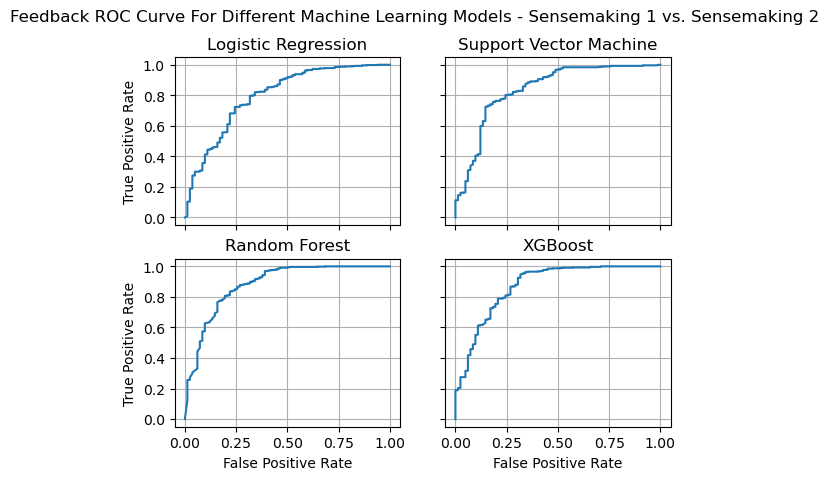

In [225]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Different Machine Learning Models - Sensemaking 1 vs. Sensemaking 2')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_LIWC_case2,tpr_log_LIWC_case2)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_LIWC_case2,tpr_svm_LIWC_case2)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_LIWC_case2,tpr_rf_LIWC_case2)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_LIWC_case2,tpr_xgb_LIWC_case2)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

Just like case 1, we can compute the feature importance using XGBoost.

In [226]:
import xgboost as xgb
# Separate the features (X) and the target variable (y)
X = features_LIWC
y = target_LIWC

# Convert the data into DMatrix format for XGBoost
dmatrix = xgb.DMatrix(X, label=y)

# Set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Train the XGBoost model
model = xgb.train(params, dmatrix)

# Get the feature importance
feature_importance = model.get_score(importance_type='weight')

# Create a DataFrame to display the feature importance
importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()),
                              'Importance': list(feature_importance.values())})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Show the top 10 most important features
top_10_features = importance_df.head(10)
print(top_10_features)

      Feature  Importance
6    BigWords        16.0
23        adj        15.0
62    AllPunc        14.0
7         Dic        13.0
63     Period        12.0
48       work        12.0
57       time        11.0
1    Analytic        11.0
3   Authentic        10.0
19    auxverb        10.0


### 4. Training the Models - Sensemaking and Impact vs. The Rest

For case 3, the LIWC extracted features have to be put through the same set of steps that were followed for case 3 in Part 1. Let us start by defining a function to create the target variable that contains the value of 1 if the text contains atleast one sensemaking rubric and one future impact rubric and 0 otherwise.

In [227]:
# Defining a function to detect the sensemaking and future impact rubrics
def sensemaking_impact(rub):

    # If condition to check for both sensemaking and future impact
    if 'Sensemaking' in rub and 'Impact' in rub:

        return 1

    else:

        return 0

# Applying the function to the data
data_LIWC['Sensemaking_Impact'] = data_LIWC['Rubric'].apply(lambda x : sensemaking_impact(x))

Let us check the value counts of the newly created target variable.

In [228]:
# Checking the value counts for the target variable
print(data_LIWC['Sensemaking_Impact'].value_counts())

Sensemaking_Impact
0    5255
1     504
Name: count, dtype: int64


Let us separately store the features and target variable for this data.

In [229]:
# Separately storing the features
features_LIWC = data_LIWC.drop(['Unnamed: 0', 'SentenceLabelRem', 'SentenceScoreRem', 'FeedbackCode', 'Rubric', 'Score', 'Sensemaking', 'Sensemaking_Impact'], axis = 1)

# Separately storing the target variable
target_LIWC = data_LIWC['Sensemaking_Impact']

Let us split the data into the training and testing data sets with the help of the `train_test_split` module of the `sklearn` library.

In [230]:
# Splitting the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(features_LIWC, target_LIWC, test_size=0.2, random_state=42)

In [231]:
# Viewing information about the train and test data sets
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4607, 119)
Number transactions y_train dataset:  (4607,)
Number transactions X_test dataset:  (1152, 119)
Number transactions y_test dataset:  (1152,)


As we observed in the value counts of the target variable, there is a class imbalance in the data. Similar to case 2, we will use the `SMOTE` oversampler from the `imblearn` library to handle the class imbalance.

In [232]:
# Reference: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Importing SMOTE from the imblearn library
from imblearn.over_sampling import SMOTE
from collections import Counter

# Defining the SMOTE function
smote = SMOTE()

# Fitting the smote function to the predictor and target variable of the training data
x_smote, y_smote = smote.fit_resample(X_train, y_train)

# Checking the before and after state of the balancing operation on the data
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 4194, 1: 413})
Resample dataset shape Counter({0: 4194, 1: 4194})


We can train the four models now with the smote-balanced data.

In [233]:
# Fitting the Logistic Regression model to the data
# Contributed by: Ahmad Aldino (ahmad.aldino@monash.edu)
lr_model_LIWC = LogisticRegression()
lr_model_LIWC.fit(x_smote, y_smote)
lr_pred_LIWC = lr_model_LIWC.predict(X_test)
lr_acc_LIWC = accuracy_score(y_test, lr_pred_LIWC)
print(classification_report(y_test, lr_pred_LIWC))

# Fitting the Support Vector Machine model to the data
svm_model_LIWC = SVC(probability=True)
svm_model_LIWC.fit(x_smote, y_smote)
svm_pred_LIWC = svm_model_LIWC.predict(X_test)
svm_acc_LIWC = accuracy_score(y_test, svm_pred_LIWC)
print(classification_report(y_test, svm_pred_LIWC))

# Fitting the Random Forest model to the data
rf_model_LIWC = RandomForestClassifier()
rf_model_LIWC.fit(x_smote, y_smote)
rf_pred_LIWC = rf_model_LIWC.predict(X_test)
rf_acc_LIWC = accuracy_score(y_test, rf_pred_LIWC)
print(classification_report(y_test, rf_pred_LIWC))

# Fitting the XGBoost model to the data
xgb_model_LIWC = XGBClassifier().fit(x_smote, y_smote)
xgb_pred_LIWC = xgb_model_LIWC.predict(X_test)
xgb_acc_LIWC = accuracy_score(xgb_pred_LIWC, y_test)
print(classification_report(y_test, xgb_pred_LIWC))

# Printing the accuracy for each model
print("Logistic Regression Accuracy:", lr_acc_LIWC)
print("Support Vector Machine Accuracy:", svm_acc_LIWC)
print("Random Forest Accuracy:", rf_acc_LIWC)
print('XGBoost Accuracy:', xgb_acc_LIWC)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1061
           1       0.28      0.79      0.42        91

    accuracy                           0.83      1152
   macro avg       0.63      0.81      0.66      1152
weighted avg       0.92      0.83      0.86      1152

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1061
           1       0.33      0.81      0.47        91

    accuracy                           0.86      1152
   macro avg       0.66      0.84      0.69      1152
weighted avg       0.93      0.86      0.88      1152

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1061
           1       0.67      0.64      0.66        91

    accuracy                           0.95      1152
   macro avg       0.82      0.81      0.81      1152
weighted avg       0.95      0.95      0.95      1152

              preci

We can now plot the ROC curves for each of the 4 models.

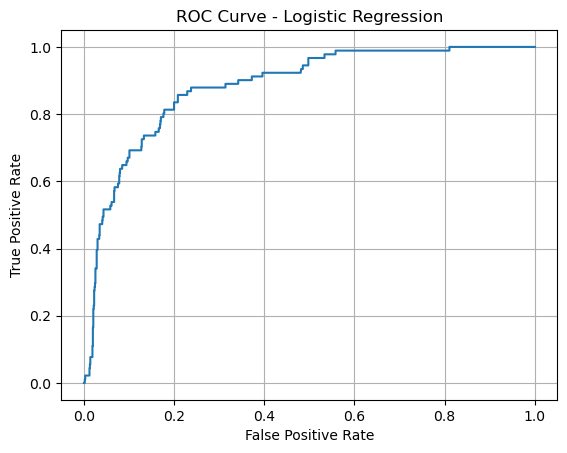

In [234]:
# Computing the metrics to plot the curve for Logistic Regression
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_log_LIWC = lr_model_LIWC.predict_proba(X_test)[::,1]
fpr_log_LIWC_case3, tpr_log_LIWC_case3, _ = roc_curve(y_test,  y_pred_proba_log_LIWC)

# Generating the ROC curve for the Logistic Regression model
plt.plot(fpr_log_LIWC_case3,tpr_log_LIWC_case3)
plt.title('ROC Curve - Logistic Regression')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

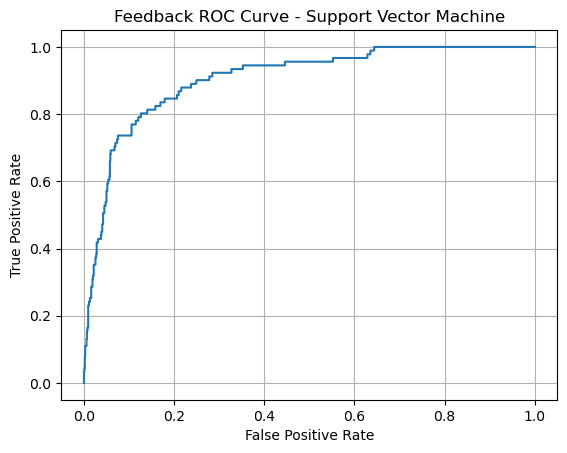

In [235]:
# Computing the metrics to plot the curve for Support Vector Machine
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_svm_LIWC = svm_model_LIWC.predict_proba(X_test)[::,1]
fpr_svm_LIWC_case3, tpr_svm_LIWC_case3, _ = roc_curve(y_test,  y_pred_proba_svm_LIWC)

# Generating the ROC curve for the SVM model
plt.plot(fpr_svm_LIWC_case3,tpr_svm_LIWC_case3)
plt.title('Feedback ROC Curve - Support Vector Machine')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

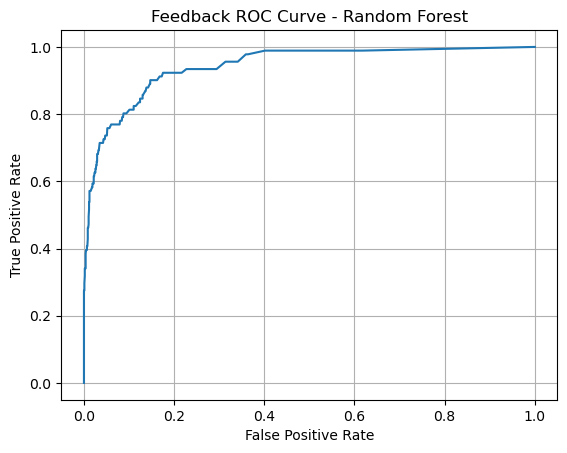

In [236]:
# Computing the metrics to plot the curve for Random Forest
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_rf_LIWC = rf_model_LIWC.predict_proba(X_test)[::,1]
fpr_rf_LIWC_case3, tpr_rf_LIWC_case3, _ = roc_curve(y_test,  y_pred_proba_rf_LIWC)

# Generating the ROC curve for the Random Forest model
plt.plot(fpr_rf_LIWC_case3,tpr_rf_LIWC_case3)
plt.title('Feedback ROC Curve - Random Forest')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

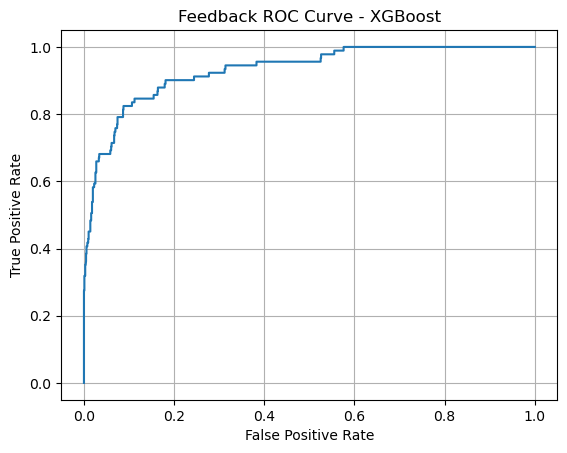

In [237]:
# Computing the metrics to plot the curve for XGBoost
# Reference: https://www.statology.org/plot-roc-curve-python/
y_pred_proba_xgb_LIWC = xgb_model_LIWC.predict_proba(X_test)[::,1]
fpr_xgb_LIWC_case3, tpr_xgb_LIWC_case3, _ = roc_curve(y_test,  y_pred_proba_xgb_LIWC)

# Generating the ROC curve for the XGBoost model
plt.plot(fpr_xgb_LIWC_case3,tpr_xgb_LIWC_case3)
plt.title('Feedback ROC Curve - XGBoost')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

Now, let us combine the ROC plots for the LIWC trained models with case 3.

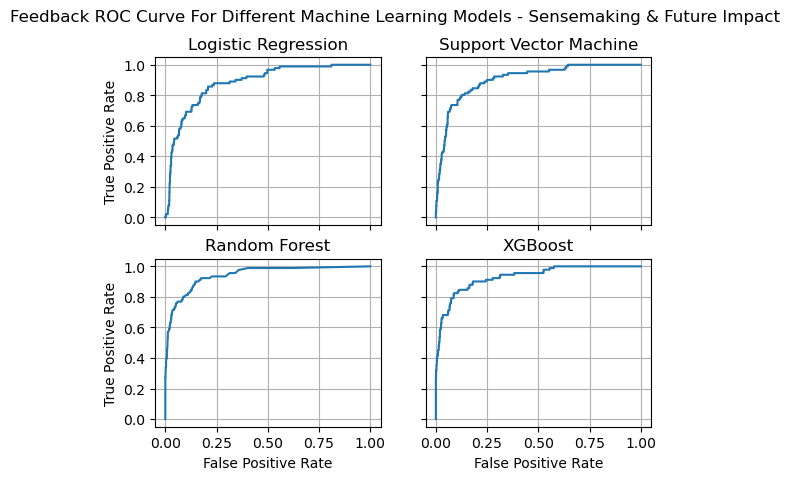

In [238]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Different Machine Learning Models - Sensemaking & Future Impact')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_LIWC_case3,tpr_log_LIWC_case3)
axs[0, 0].set_title('Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_LIWC_case3,tpr_svm_LIWC_case3)
axs[0, 1].set_title('Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_LIWC_case3,tpr_rf_LIWC_case3)
axs[1, 0].set_title('Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_LIWC_case3,tpr_xgb_LIWC_case3)
axs[1, 1].set_title('XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

Let us use XGBoost to compute the feature importance for the features that were instrumental in affecting the model performance.

In [239]:
# Importing the xgboost library
import xgboost as xgb

# Separating the features (X) and the target variable (y)
X = features_LIWC
y = target_LIWC

# Converting the data into DMatrix format for XGBoost
dmatrix = xgb.DMatrix(X, label=y)

# Setting the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Training the XGBoost model
model = xgb.train(params, dmatrix)

# Getting the feature importance
feature_importance = model.get_score(importance_type='weight')

# Creating a DataFrame to display the feature importance
importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()),
                              'Importance': list(feature_importance.values())})

# Sorting the DataFrame
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Collecting the top 10 most important features
top_10_features = importance_df.head(10)

# Checking the top 10 features
print(top_10_features)

         Feature  Importance
0             WC        33.0
5            WPS        17.0
35       discrep        15.0
74         Comma        13.0
69  focuspresent        11.0
1       Analytic        10.0
7            Dic        10.0
3      Authentic         9.0
4           Tone         9.0
62        motion         9.0


### 5 Combining the ROC Curves for the Best Results from Part 1 (TF-IDF) and Part 2 (LIWC)

In this notebook, we trained four 4 model types across 3 different scenarios. The training of the model was based on two different feature extraction methods, TF-IDF and LIWC. Let us compile the ROC curves for the best performing models overall for each case.

#### Case 1: Sensemaking vs. The Rest

The Best performing models for the first case are:

- TF-IDF-Logistic Regression
- TF-IDF-Support Vector Machine
- TF-IDF-Random Forest
- LIWC-XGBoost

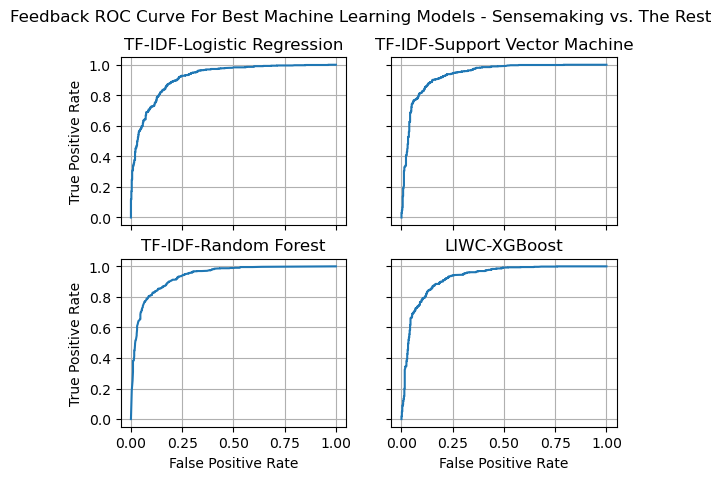

In [244]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Best Machine Learning Models - Sensemaking vs. The Rest')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case1,tpr_log_case1)
axs[0, 0].set_title('TF-IDF-Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case1,tpr_svm_case1)
axs[0, 1].set_title('TF-IDF-Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_case1,tpr_rf_case1)
axs[1, 0].set_title('TF-IDF-Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_LIWC_case1,tpr_xgb_LIWC_case1)
axs[1, 1].set_title('LIWC-XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

#### Case 2: Sensemaking 1 vs. Sensemaking 2

The Best performing models for the second case are:

- TF-IDF-Logistic Regression
- TF-IDF-Support Vector Machine
- TF-IDF-Random Forest
- TF-IDF-XGBoost

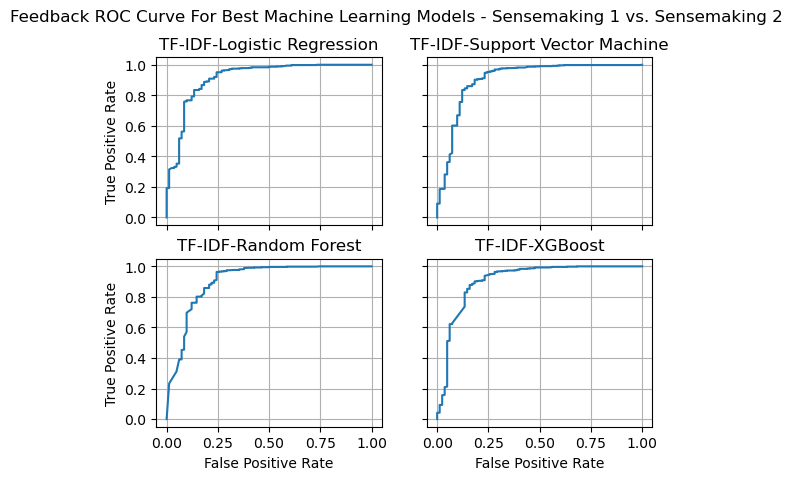

In [243]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Best Machine Learning Models - Sensemaking 1 vs. Sensemaking 2')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case2,tpr_log_case2)
axs[0, 0].set_title('TF-IDF-Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case2,tpr_svm_case2)
axs[0, 1].set_title('TF-IDF-Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_case2,tpr_rf_case2)
axs[1, 0].set_title('TF-IDF-Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_case2,tpr_xgb_case2)
axs[1, 1].set_title('TF-IDF-XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()

#### Case 3: Sensemaking & Impact vs. The Rest

The Best performing models for the third case are:

- TF-IDF-Logistic Regression
- TF-IDF-Support Vector Machine
- LIWC-Random Forest
- LIWC-XGBoost

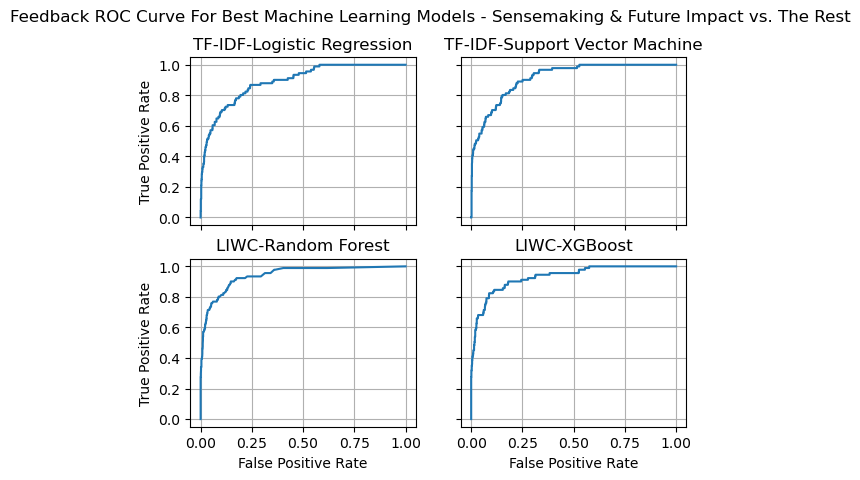

In [242]:
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Defining the subplot
fig, axs = plt.subplots(2, 2)

# Defining the title of the plot
fig.suptitle('Feedback ROC Curve For Best Machine Learning Models - Sensemaking & Future Impact vs. The Rest')

# Generating the ROC curve for the Logistic Regression Model
axs[0, 0].plot(fpr_log_case3,tpr_log_case3)
axs[0, 0].set_title('TF-IDF-Logistic Regression')

# Enabling the grid
axs[0, 0].grid()

# Generating the ROC curve for the SVM model
axs[0, 1].plot(fpr_svm_case3,tpr_svm_case3)
axs[0, 1].set_title('TF-IDF-Support Vector Machine')

# Enabling the grid
axs[0, 1].grid()

# Generating the ROC curve for the Random Forest model
axs[1, 0].plot(fpr_rf_LIWC_case3,tpr_rf_LIWC_case3)
axs[1, 0].set_title('LIWC-Random Forest')

# Enabling the grid
axs[1, 0].grid()

# Creating the ROC curve for the XGBoost Model
axs[1, 1].plot(fpr_xgb_LIWC_case3,tpr_xgb_LIWC_case3)
axs[1, 1].set_title('LIWC-XGBoost')

# Enabling the grid
axs[1, 1].grid()

for ax in axs.flat:
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Displaying the Plot
plt.show()